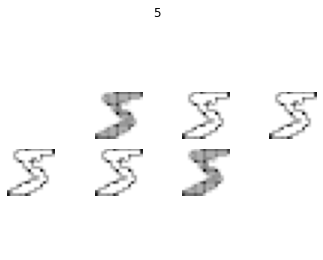

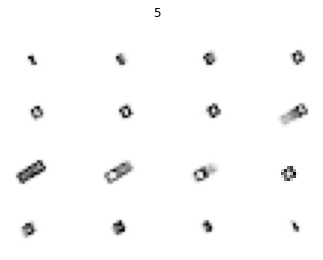

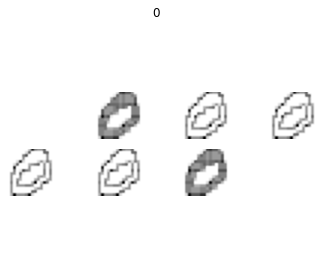

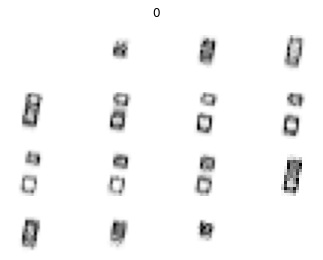

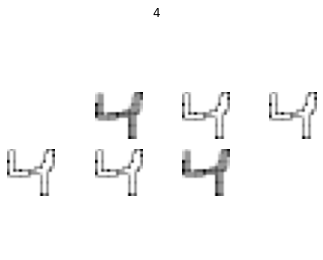

In [4]:
import h5py
import os
import matplotlib.pyplot as plt
import numpy as np

data_path = os.path.join(os.path.expanduser('~'), 'data', '3d-mnist', 
                         'full_dataset_vectors.h5')

assert os.path.isfile(data_path), \
    'Download the 3d-mnist data from https://www.kaggle.com/daavoo/3d-mnist'

with h5py.File(data_path, 'r') as f:
    train_X = np.reshape(f["X_train"][:], (-1, 16, 16, 16, 1))
    train_y = f["y_train"][:]    
    test_X = np.reshape(f["X_test"][:]  , (-1, 16, 16, 16, 1))
    test_y = f["y_test"][:]

train_X = train_X[:,::-1,:,:]
test_X = test_X[:,::-1,:,:]

def onehot(values: np.ndarray) -> np.ndarray:
    encoded = np.zeros((len(values), 10))

    for i in range(len(values)):
        encoded[i,values[i]] = 1

    return encoded

train_y = onehot(train_y)
test_y = onehot(test_y)

for i in range(5):
    fig, ax = plt.subplots(4, 4)
    fig.suptitle(str(np.argmax(train_y[i])))
    ax = ax.ravel()

    for j in range(16):
        ax[j].imshow(train_X[i,:,:,j], cmap='Greys')
        ax[j].axis('off')

    plt.show()

In [5]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Activation, BatchNormalization, Conv3D, Dense, \
                                    Dropout, Flatten, \
                                    GlobalAveragePooling3D, Input, \
                                    MaxPooling3D
from tensorflow.keras.regularizers import l2

inputs = Input((16, 16, 16, 1), name='inputs')

x = inputs

kernel = (3, 3, 3)
dropout = 0.3
weight_decay = 1e-3
regularizer = l2(weight_decay)

x = Conv3D(32, kernel, padding='SAME', activation=None, 
           kernel_regularizer=regularizer, name='conv1')(x)
x = BatchNormalization(name='norm1')(x)
x = Activation('relu')(x)
x = Conv3D(32, kernel, padding='SAME', activation=None, 
           kernel_regularizer=regularizer, name='conv2')(x)
x = BatchNormalization(name='norm2')(x)
x = Activation('relu')(x)
x = MaxPooling3D((2, 2, 2), name='pool1')(x)
x = Conv3D(64, kernel, padding='SAME', activation=None, 
           kernel_regularizer=regularizer, name='conv3')(x)
x = BatchNormalization(name='norm3')(x)
x = Activation('relu')(x)
x = Conv3D(64, kernel, padding='SAME', activation=None, 
           kernel_regularizer=regularizer, name='conv4')(x)
x = BatchNormalization(name='norm4')(x)
x = Activation('relu')(x)
x = MaxPooling3D((2, 2, 2), name='pool2')(x)
x = Conv3D(128, kernel, padding='SAME', activation=None, 
           kernel_regularizer=regularizer, name='conv5')(x)
x = BatchNormalization(name='norm5')(x)
x = Activation('relu')(x)
x = Conv3D(128, kernel, padding='SAME', activation=None, 
           kernel_regularizer=regularizer, name='conv6')(x)
x = BatchNormalization(name='norm6')(x)
x = MaxPooling3D((2, 2, 2), name='pool3')(x)
x = Conv3D(256, kernel, padding='SAME', activation=None, 
           kernel_regularizer=regularizer, name='conv7')(x)
x = BatchNormalization(name='norm7')(x)
x = Activation('relu')(x)
x = Conv3D(256, kernel, padding='SAME', activation=None, 
           kernel_regularizer=regularizer, name='conv8')(x)
x = BatchNormalization(name='norm8')(x)
x = Activation('relu')(x)
x = GlobalAveragePooling3D(name='pool4')(x)
x = Dropout(dropout)(x)
x = Dense(10, kernel_regularizer=regularizer, activation=None, name='dense')(x)
x = BatchNormalization(name='norm9')(x)
x = Activation('relu')(x)
x = Dropout(dropout)(x)
x = Dense(10, activation='softmax', name='preds')(x)

model = Model(inputs, x)
model.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, 16, 16, 16, 1)]   0         
_________________________________________________________________
conv1 (Conv3D)               (None, 16, 16, 16, 32)    896       
_________________________________________________________________
norm1 (BatchNormalization)   (None, 16, 16, 16, 32)    128       
_________________________________________________________________
activation (Activation)      (None, 16, 16, 16, 32)    0         
_________________________________________________________________
conv2 (Conv3D)               (None, 16, 16, 16, 32)    27680     
_________________________________________________________________
norm2 (BatchNormalization)   (None, 16, 16, 16, 32)    128       
_________________________________________________________________
activation_1 (Activation)    (None, 16, 16, 16, 32)    0     

2022-03-12 20:40:40.894312: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-12 20:40:40.894558: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-12 20:40:40.894679: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-12 20:40:41.218628: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-12 20:40:41.218807: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

In [6]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

model.compile(loss='categorical_crossentropy', optimizer=Adam(1e-3),
              metrics=['accuracy'])

callbacks = [
    ReduceLROnPlateau(
        monitor="loss",
        factor=0.1,
        patience=5,
        verbose=1
    )
]

model.fit(train_X, train_y, 
          validation_data=(test_X, test_y), 
          epochs=100, 
          batch_size=32, 
          shuffle=True,
          callbacks=callbacks)

2022-03-12 20:40:42.026123: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100


2022-03-12 20:40:43.371977: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8100
2022-03-12 20:40:43.565489: W tensorflow/stream_executor/gpu/asm_compiler.cc:113] *** WARNING *** You are using ptxas 9.1.108, which is older than 9.2.88. ptxas 9.x before 9.2.88 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You do not need to update to CUDA 9.2.88; cherry-picking the ptxas binary is sufficient.


313/313 [==============================] - 9s 22ms/step - loss: 2.5740 - accuracy: 0.2812 - val_loss: 2.6373 - val_accuracy: 0.1495
Epoch 2/100
313/313 [==============================] - 7s 21ms/step - loss: 1.9194 - accuracy: 0.4409 - val_loss: 1.8866 - val_accuracy: 0.4190
Epoch 3/100
313/313 [==============================] - 7s 21ms/step - loss: 1.7393 - accuracy: 0.5004 - val_loss: 1.6629 - val_accuracy: 0.5580
Epoch 4/100
313/313 [==============================] - 7s 21ms/step - loss: 1.6367 - accuracy: 0.5386 - val_loss: 1.6831 - val_accuracy: 0.5310
Epoch 5/100
313/313 [==============================] - 7s 21ms/step - loss: 1.6139 - accuracy: 0.5500 - val_loss: 1.5042 - val_accuracy: 0.5885
Epoch 6/100
313/313 [==============================] - 7s 21ms/step - loss: 1.5671 - accuracy: 0.5739 - val_loss: 1.5661 - val_accuracy: 0.6120
Epoch 7/100
313/313 [==============================] - 7s 21ms/step - loss: 1.5490 - accuracy: 0.5838 - val_loss: 1.4742 - val_accuracy: 0.6090
Epoc

313/313 [==============================] - 7s 22ms/step - loss: 0.5054 - accuracy: 0.9292 - val_loss: 0.9995 - val_accuracy: 0.8265
Epoch 58/100
313/313 [==============================] - 7s 23ms/step - loss: 0.5083 - accuracy: 0.9224 - val_loss: 0.9910 - val_accuracy: 0.8325
Epoch 59/100
313/313 [==============================] - 7s 22ms/step - loss: 0.4887 - accuracy: 0.9302 - val_loss: 1.0125 - val_accuracy: 0.8230
Epoch 60/100
313/313 [==============================] - 7s 23ms/step - loss: 0.4794 - accuracy: 0.9291 - val_loss: 1.0433 - val_accuracy: 0.8180
Epoch 61/100
313/313 [==============================] - 7s 22ms/step - loss: 0.4778 - accuracy: 0.9266 - val_loss: 1.0026 - val_accuracy: 0.8325
Epoch 62/100
313/313 [==============================] - 7s 23ms/step - loss: 0.4777 - accuracy: 0.9242 - val_loss: 1.0028 - val_accuracy: 0.8310
Epoch 63/100
313/313 [==============================] - 7s 23ms/step - loss: 0.4600 - accuracy: 0.9322 - val_loss: 1.0177 - val_accuracy: 0.828

In [12]:
from explainability import LayerwiseRelevancePropagator

image_idx = 0

explanations = np.zeros((10, 16, 16, 16, 1))
predictions = model.predict(train_X[image_idx:image_idx + 1])
print(f'Predictions: {predictions[0]}')

for i in range(10):
    explainer = LayerwiseRelevancePropagator(model, layer=33, idx=i, alpha=2, beta=1)
    explanations[i] = explainer(train_X[image_idx:image_idx + 1])
    print(f'Sum evidence for {i}: {np.sum(explanations[i])}')

Predictions: [4.1865981e-08 1.4147719e-10 3.2737089e-04 5.7389090e-05 7.1149157e-06
 9.9907160e-01 1.0164841e-06 4.4236076e-06 5.3075748e-04 1.8444251e-07]
Sum evidence for 0: -197939.73342514038
Sum evidence for 1: -310110.07038116455
Sum evidence for 2: -37357.998927116394
Sum evidence for 3: -71644.26559448242
Sum evidence for 4: -104995.9107131958
Sum evidence for 5: 223806.0030822754
Sum evidence for 6: -144184.0288848877
Sum evidence for 7: -115409.48547744751
Sum evidence for 8: -28661.890153884888
Sum evidence for 9: -172753.05445480347


In [13]:
model.save_weights('/home/esten/tmp_weights.hdf5')

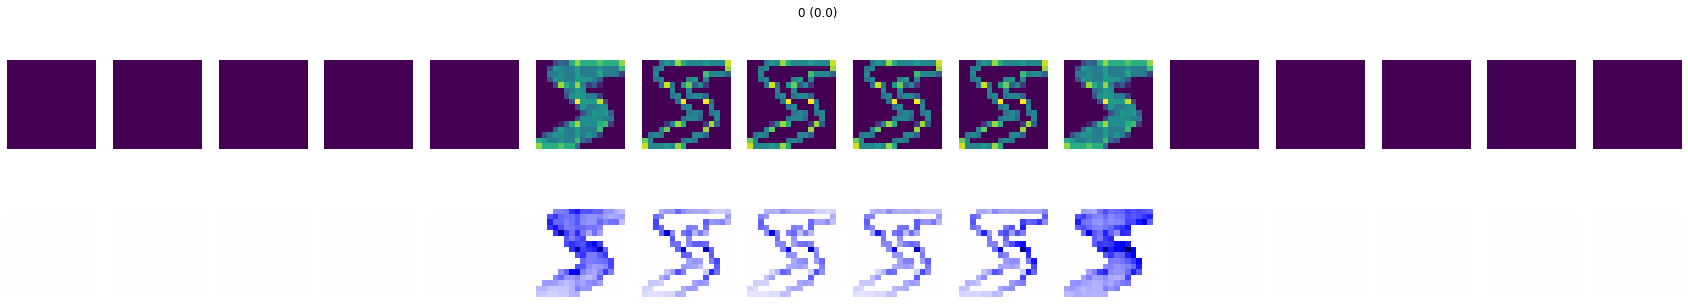

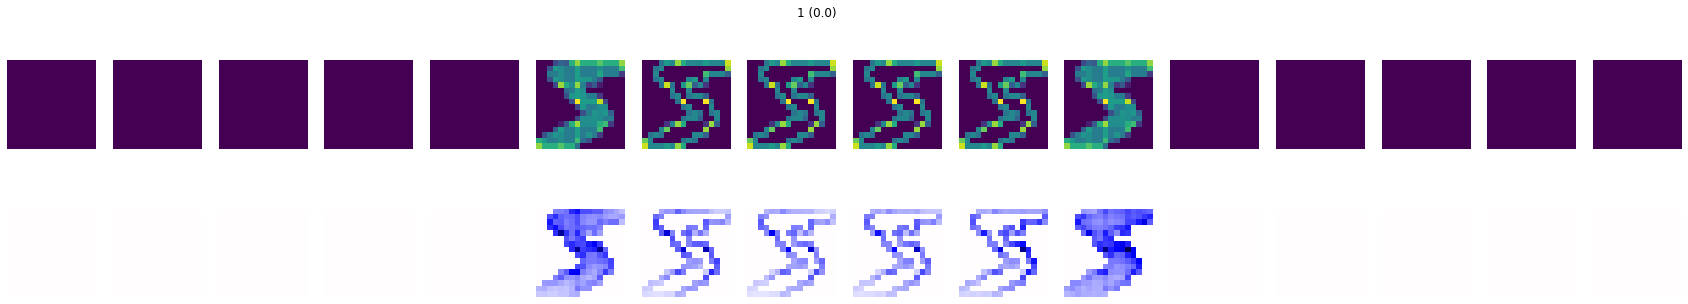

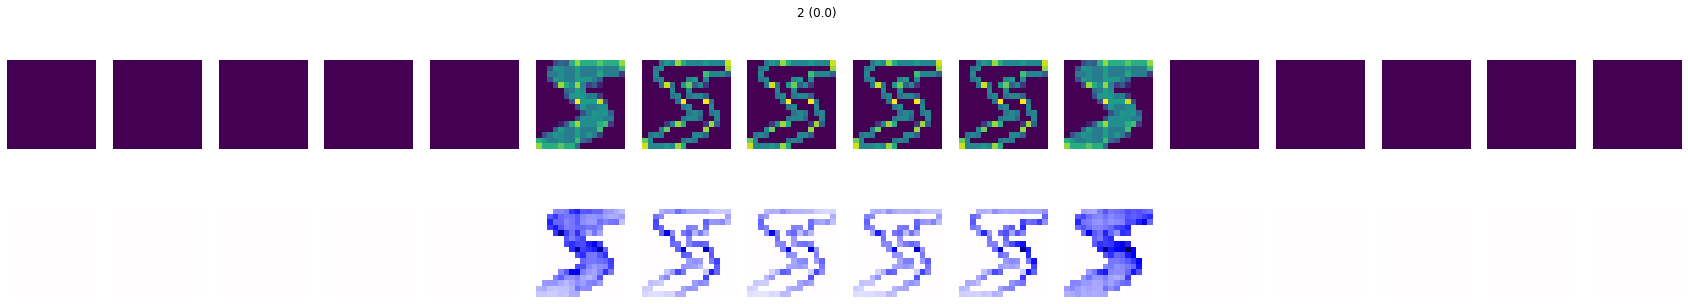

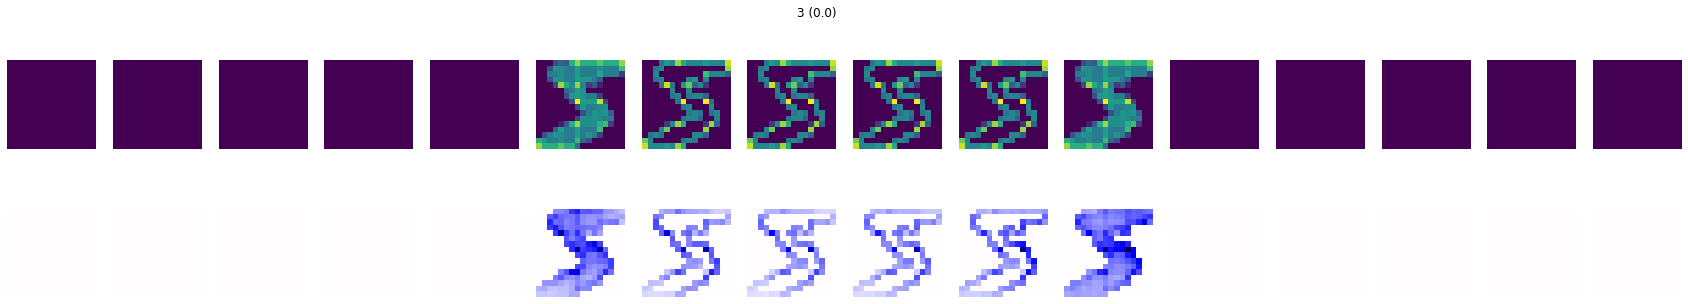

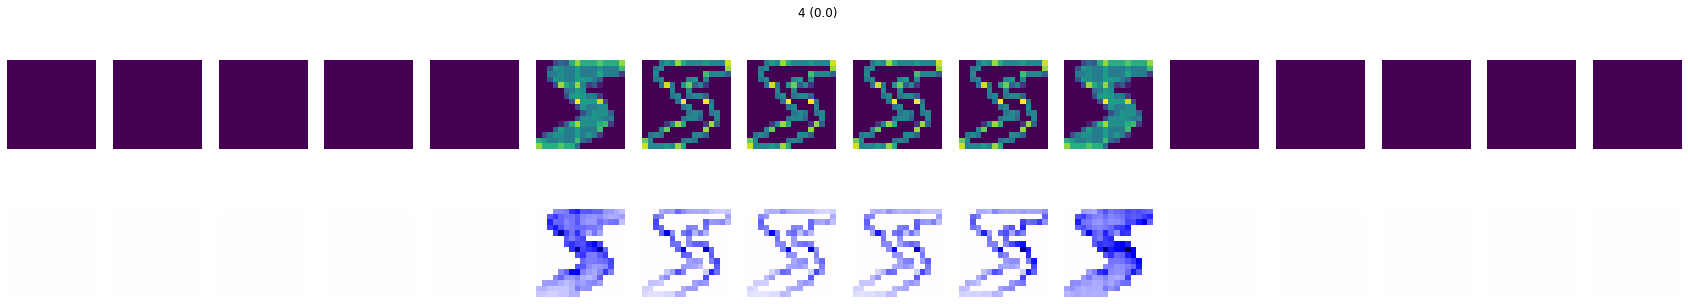

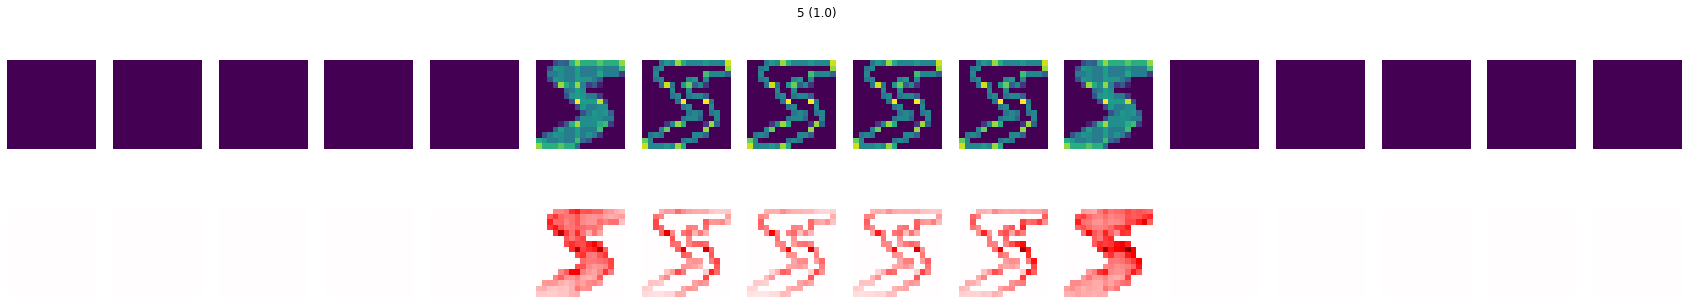

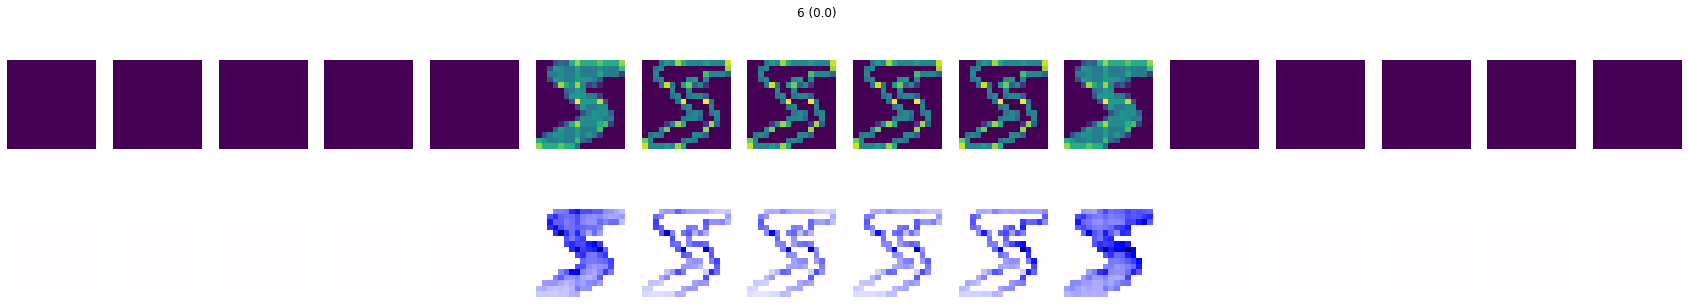

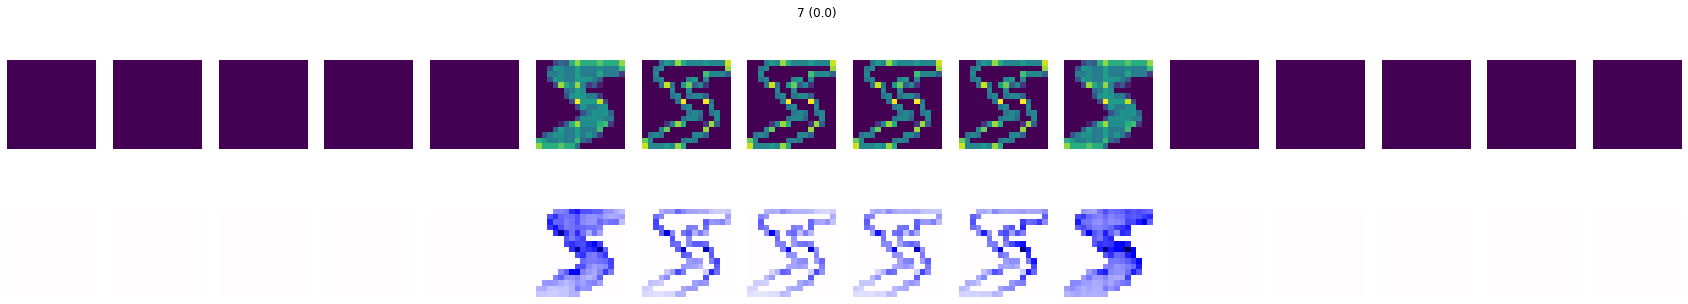

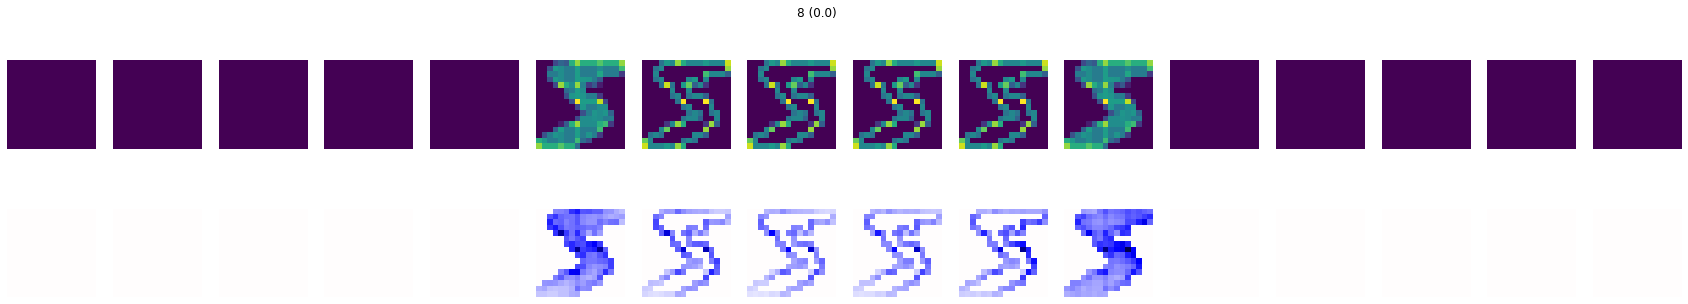

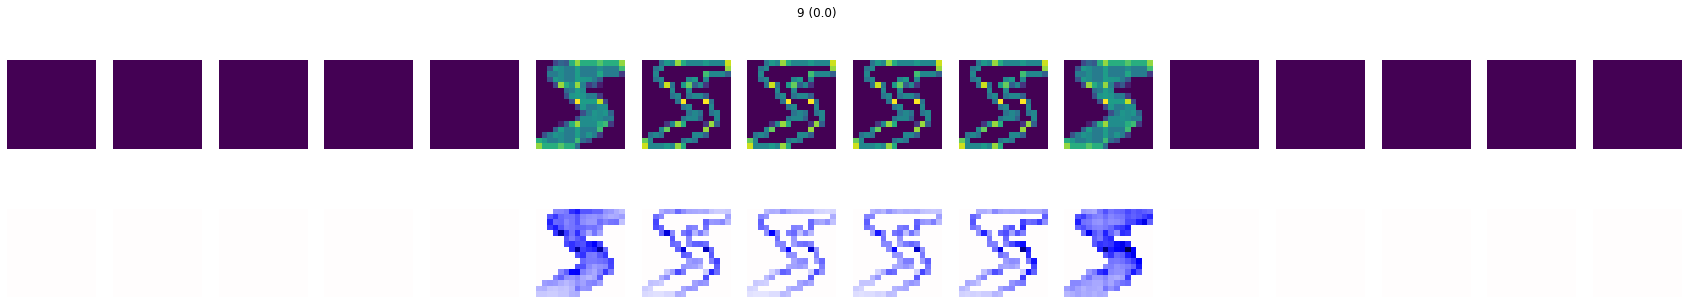

In [14]:
for i in range(len(explanations)):
    explanations[i] = explanations[i] / np.amax(np.abs(explanations[i]))
    explanations[i] -= explanations[i,0,0,0,0]
    
    fig, ax = plt.subplots(2, 16, figsize=(30, 5))
    fig.suptitle(f'{i} ({round(predictions[0,i], 2)})')
    
    for j in range(16):
        ax[0][j].imshow(train_X[image_idx,:,:,j])
        ax[1][j].imshow(explanations[i,:,:,j], cmap='seismic', clim=(-1, 1))
        ax[0][j].axis('off')
        ax[1][j].axis('off')
        
    plt.show()

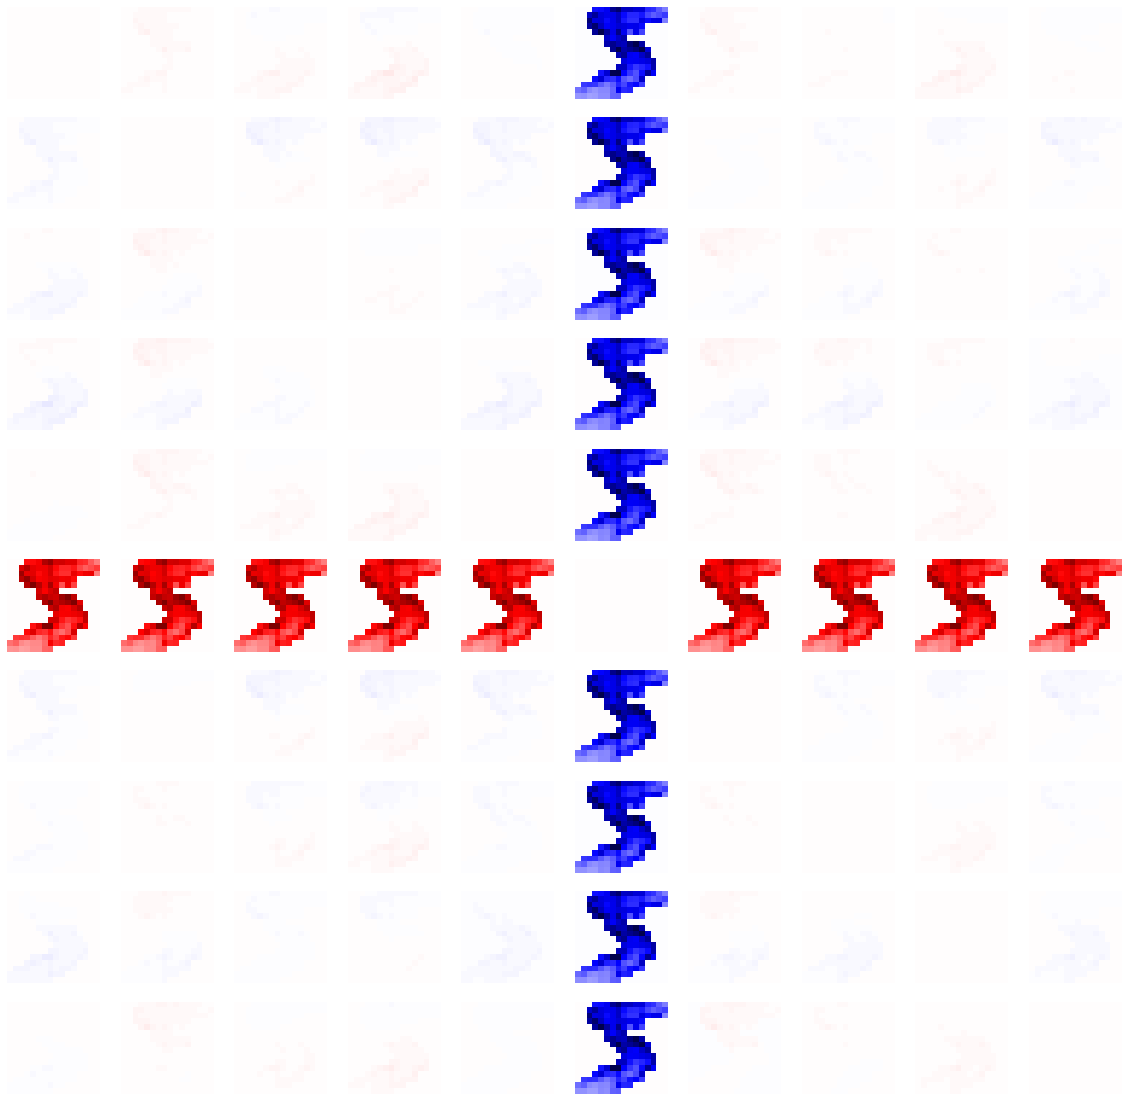

In [15]:
fig, ax = plt.subplots(10, 10, figsize=(20, 20))

for i in range(10):
    for j in range(10):
        ax[i][j].axis('off')
        ax[i][j].imshow(explanations[i,:,:,5] - explanations[j,:,:,5], cmap='seismic', clim=(-1, 1))
        
plt.show()

In [13]:
layers = [
    (33, 'prediction'),
    (35, 'mask'),
    (36, 'dense')
]

#for i in range(len(explainer.layers)):
#    print(f'{i}: {explainer.layers[i]}')

for layer, description in layers:
    layerwise_explanations = []
    for i in range(1):
        explainer = LayerwiseRelevancePropagator(model, layer=33, idx=i, alpha=1, beta=0)
        layerwise_explanations.append(explainer(train_X[image_idx:]))
        
    print(layerwise_explanations[0].shape)

2022-03-11 23:11:00.764319: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 327680000 exceeds 10% of free system memory.
2022-03-11 23:11:00.979159: W tensorflow/core/kernels/gpu_utils.cc:49] Failed to allocate memory for convolution redzone checking; skipping this check. This is benign and only means that we won't check cudnn for out-of-bounds reads and writes. This message will only be printed once.
2022-03-11 23:11:11.068557: W tensorflow/core/common_runtime/bfc_allocator.cc:457] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.88GiB (rounded to 5242880000)requested by op Relu
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2022-03-11 23:11:11.068643: I tensorflow/core/common_runtime/bfc_allocator.cc:1004] BFCAllocator dump for GPU_0_bfc
2022-03-11 23:11:11.068685: I tensorflow/core/common_runtim

ResourceExhaustedError: OOM when allocating tensor with shape[10000,16,16,16,32] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:Relu]